
*   Возьмите базу жанров музыки.
*   Обучите вариационный автокодировщик на всей базе на основе спектрограмм (mfcc).
*  Сделайте генерацию спектрограмм с помощью VAE. 
*   Сделайте обратное превращение из спектра в аудио с помощью librosa.feature.inverse.mfcc_to_audio.


In [ ]:
# Загрузка библиотек
from google.colab import files
import os   # Работа с ОС
import sys # модуль содержит параметры и функции, которые относятся к Python и его среде
import numpy as np # загружаем библиотеку для работы с массивами данны
import librosa    # Параметризация аудио
import librosa.display #Для отображения аудио сигналов
import IPython.display as ipd # Для проигрывания аудио
from scipy.io.wavfile import write
from IPython.display import clear_output # импортируем модуль очистки output'а ячейки
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
%matplotlib inline

In [ ]:
!unzip -q '/content/drive/MyDrive/genres.zip'

Выберем параметр n_mfcc

In [ ]:
y, sr = librosa.load('/content/genres/classical/classical.00005.au', mono=True, duration=3)
mfcc = librosa.feature.mfcc(y, sr,n_mfcc=80)
y_inv = librosa.feature.inverse.mfcc_to_audio(mfcc)
write('/content/drive/MyDrive/y_inv.wav', sr, y_inv)
ipd.Audio('/content/drive/MyDrive/y_inv.wav')

In [ ]:
mfcc = librosa.feature.mfcc(y, sr,n_mfcc=40)
y_inv = librosa.feature.inverse.mfcc_to_audio(mfcc)
write('/content/drive/MyDrive/y_inv.wav', sr, y_inv)
ipd.Audio('/content/drive/MyDrive/y_inv.wav')

 

*   При n_mfcc = 40 и ниже в восстановленом звуке присутствует рокот. 
*   Остановимся на n_mfcc = 80



**Формирование обучающей выборки**

In [ ]:
def get_mfcc(y, sr):
  return librosa.feature.mfcc(y=y, sr=sr, n_mfcc=80)                   # Мел спектральные коэффициенты

x_t = []
genres = sorted(os.listdir('genres'))
for i in range(len(genres)):    # Проходим по всем жанрам
  g = genres[i]                 # текущий жанр
  for filename in os.listdir(f'./genres/{g}'):  # по файлам папки, соответствующей текущему жанру
    songname = f'./genres/{g}/{filename}'
    y, sr = librosa.load(songname, mono=True, duration=30)

    for sec in range(0,27,3):         # Превращаем сигнал в параметризованные данные
      mfcc = get_mfcc(y[sec*sr:(sec+2)*sr+500], sr)   
      x_t.append(mfcc)

  print("Жанр ", g, " готов ", sep="")     #  информация о готовности 

x_train = np.array(x_t)
x_train.shape

Жанр blues готов 
Жанр classical готов 
Жанр country готов 
Жанр disco готов 
Жанр hiphop готов 
Жанр jazz готов 
Жанр metal готов 
Жанр pop готов 
Жанр reggae готов 
Жанр rock готов 


(9000, 80, 88)

In [ ]:
x_train = np.array(x_t)
print(np.min(x_train), np.max(x_train), np.mean(x_train)) # Характеристики исхoдного сигнала
x_train = np.arctan(x_train/10)/np.pi + 0.5               # Маштабируем, малые уровни - линейно, большие со сжатием
print(np.min(x_train), np.max(x_train), np.mean(x_train)) # После масштабирования

-1131.3708 276.00842 -1.0063564
0.0028134286 0.98847246 0.48078993


In [ ]:
x_train = x_train.reshape(9000, 80, 88, 1)        #  Подготовка x_train, x_test 
x_train, x_test = train_test_split(x_train,  test_size=1./9., shuffle=True) 
print(x_train.shape, x_test.shape)

(8000, 80, 88, 1) (1000, 80, 88, 1)


**Создание модели.**

*   Воспользуемся материалом из:
*  https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/generative/ipynb/vae.ipynb#scrollTo=cjIvPXGn1kua



In [ ]:
# Создаeм слой сэмплирования
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
# Собираем кодировщик
latent_dim = 32

encoder_inputs = keras.Input(shape=(80, 88, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 80, 88, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 40, 44, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 40, 44, 32)   128         conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 20, 22, 64)   18496       batch_normalization_6[0][0]      
____________________________________________________________________________________________

In [ ]:
# Собираем декодировщик
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(10 * 11 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((10, 11, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 14080)             464640    
_________________________________________________________________
reshape_1 (Reshape)          (None, 10, 11, 128)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 20, 22, 128)       147584    
_________________________________________________________________
batch_normalization_9 (Batch (None, 20, 22, 128)       512       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 40, 44, 64)        73792     
_________________________________________________________________
batch_normalization_10 (Batc (None, 40, 44, 64)        256 

In [ ]:
# Определяем VAE как модель с настраиваемым train_step
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
vae.fit(x_train, epochs=160, batch_size=16)   # Обучение

Epoch 1/160
500/500 [==============================] - 9s 15ms/step - loss: 4561.1181 - reconstruction_loss: 4516.8672 - kl_loss: 43.3934
Epoch 2/160
500/500 [==============================] - 7s 15ms/step - loss: 4558.8490 - reconstruction_loss: 4515.6646 - kl_loss: 43.4408
Epoch 3/160
500/500 [==============================] - 7s 15ms/step - loss: 4556.5044 - reconstruction_loss: 4514.7993 - kl_loss: 43.6102
Epoch 4/160
500/500 [==============================] - 7s 15ms/step - loss: 4558.8102 - reconstruction_loss: 4514.3320 - kl_loss: 43.6028
Epoch 5/160
500/500 [==============================] - 7s 15ms/step - loss: 4559.2853 - reconstruction_loss: 4514.2437 - kl_loss: 43.6089
Epoch 6/160
500/500 [==============================] - 7s 15ms/step - loss: 4555.0816 - reconstruction_loss: 4513.6899 - kl_loss: 43.7010
Epoch 7/160
500/500 [==============================] - 7s 15ms/step - loss: 4557.2024 - reconstruction_loss: 4513.3486 - kl_loss: 43.6511
Epoch 8/160
500/500 [=============

In [ ]:
vae.decoder.save_weights('/content/drive/MyDrive/decvae.h5')      # Сохранимся

In [ ]:
vae.encoder.save_weights('/content/drive/MyDrive/encvae.h5')

**Генерация спектрограмм и звука**

In [ ]:
def wshow(x, lplot=0) :         # Подпрограмма визуализации и озвучивания
  x = x.reshape(80,88) 
  x = 10*np.tan((x-0.5)*np.pi)  # Обратное масштабирование с исходным величинам
  if (lplot == 1):
    plt.figure(figsize=(7,5)) # задаем способ отрисовки картинок
    librosa.display.specshow(x, sr=sr, x_axis='time') # Отобразим спектрограммы
    plt.show()
  y_inv = librosa.feature.inverse.mfcc_to_audio(x)        # Восстановленный фрагмента музыки из спектрограммы
  write('/content/drive/MyDrive/y_i.wav', sr, y_inv)      # Записываем восстановленный фрагмент музыки
  return ipd.Audio('/content/drive/MyDrive/y_i.wav')      # Возвращаем проигрыватель

Попытка создания фрагмента музыки из шума



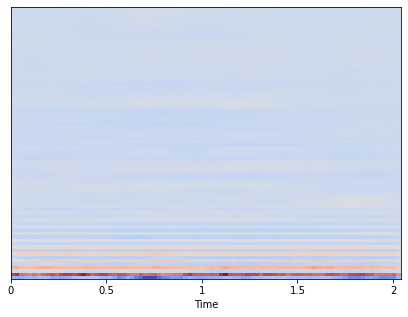

In [ ]:
z_sample = np.random.normal(loc=0, scale=1, size=[1, latent_dim])
x_decoded = vae.decoder.predict(z_sample)
pred = x_decoded[0].reshape(80, 88)
wshow(pred,1)

Пактически - шум. Проводим дообучение.

In [ ]:
vae.decoder.load_weights('/content/drive/MyDrive/decvae.h5')

In [ ]:
vae.encoder.load_weights('/content/drive/MyDrive/encvae.h5')

In [ ]:
vae.fit(x_train, epochs=160, batch_size=16)

Epoch 1/160
500/500 [==============================] - 22s 15ms/step - loss: 4552.2130 - reconstruction_loss: 4510.0610 - kl_loss: 45.3628
Epoch 2/160
500/500 [==============================] - 7s 15ms/step - loss: 4555.6744 - reconstruction_loss: 4508.7769 - kl_loss: 45.4446
Epoch 3/160
500/500 [==============================] - 8s 15ms/step - loss: 4552.3274 - reconstruction_loss: 4508.2227 - kl_loss: 45.4798
Epoch 4/160
500/500 [==============================] - 8s 15ms/step - loss: 4552.7463 - reconstruction_loss: 4507.6099 - kl_loss: 45.5656
Epoch 5/160
500/500 [==============================] - 8s 15ms/step - loss: 4553.6899 - reconstruction_loss: 4507.4683 - kl_loss: 45.6180
Epoch 6/160
500/500 [==============================] - 8s 15ms/step - loss: 4553.2017 - reconstruction_loss: 4507.2612 - kl_loss: 45.5332
Epoch 7/160
500/500 [==============================] - 8s 15ms/step - loss: 4551.5661 - reconstruction_loss: 4506.9429 - kl_loss: 45.6488
Epoch 8/160
500/500 [============

Сочиняем музыку

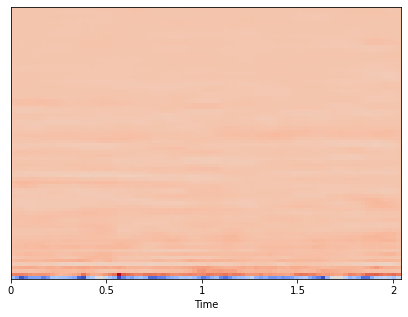

In [ ]:
z_sample = np.random.normal(loc=0, scale=1, size=[1, latent_dim])
x_decoded = vae.decoder.predict(z_sample)
pred = x_decoded[0].reshape(80, 88)
wshow(pred,1)

Более удачный вариатнт, уже не просто шум.

Воссоздание фрагмента  x_test[0]

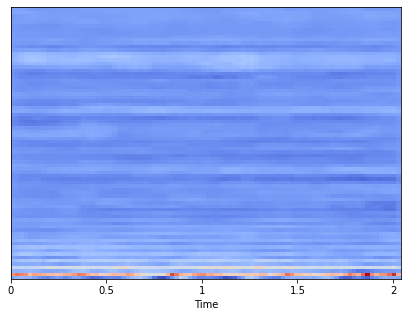

In [ ]:
x_decoded = decoder.predict(np.array(encoder.predict(x_test[0:1]))[2])
pred = x_decoded[0].reshape(80, 88)
wshow(pred,1)

Вид и звучание фрагмента x_test[0]

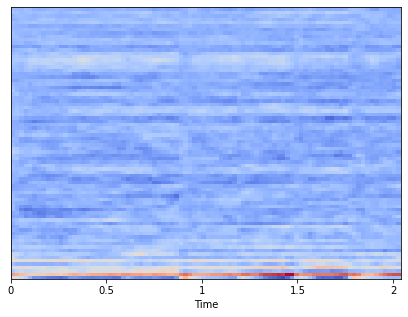

In [ ]:
wshow(x_test[0],1)

Сходство присутствует